In [138]:
import numpy as np
import pandas as pd
from faker import Faker
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import random

def generate_fake_injury_data(n_individuals = 12, time_span = 2, injury_onset_incidence = 0.01, injury_duration_mean = 10, injury_duration_std = 3):
    fake = Faker()
    end_date = datetime.today()
    start_date = end_date - timedelta(days=int(time_span * 365))
    date_range = pd.date_range(start=start_date, end=end_date)
    
    data = []
    
    for user_id in range(1, n_individuals + 1):
        user_name = fake.name()
        currently_injured = False
        injury_end_date = None
        injury_idx = None
        
        for date in date_range:
            injury_onset = False
            
            if not currently_injured and np.random.rand() < injury_onset_incidence:
                injury_onset = True
                duration = max(1, int(np.random.normal(injury_duration_mean, injury_duration_std)))
                injury_end_date = date + timedelta(days=duration)
                currently_injured = True
                injury_idx = f'{user_id}_{date.strftime("%d_%m_%Y")}'
            
            if currently_injured and date >= injury_end_date:
                currently_injured = False
                injury_end_date = None
                injury_idx = None
            
            data.append([user_id, user_name, date, injury_onset, currently_injured, injury_idx])
    
    df = pd.DataFrame(data, columns=["user_id", "user_name", "date", "injury_onset", "currently_injured", 'injury_idx'])
    
    return df

# Example usage:
injury_data = generate_fake_injury_data(n_individuals = 12, time_span = 2, injury_onset_incidence = 0.01, injury_duration_mean = 10, injury_duration_std = 3)

In [139]:
def add_days_until_next_injury(df_user_id):
     df_user_id['days_until_next_injury'] = np.nan
     for injury_idx in df_user_id['injury_idx'].unique():
          if str(injury_idx) == 'nan' or injury_idx is None:
               continue
          cur_injury = df_user_id.loc[df_user_id['injury_idx'] == injury_idx,:]
          cur_injury_date = cur_injury['date'].iloc[0]
          prior_to_injury_bool = (df_user_id['date'] <= cur_injury_date) & (df_user_id['days_until_next_injury'].isnull())
          delta_time = cur_injury_date - df_user_id['date']
          df_user_id.loc[prior_to_injury_bool, 'days_until_next_injury'] = delta_time.loc[prior_to_injury_bool].dt.days
               
     return df_user_id

injury_data = injury_data.groupby('user_id', group_keys=False).apply(add_days_until_next_injury).reset_index(drop=True)


C:\Users\rmeer\AppData\Local\Temp\ipykernel_26172\2705719176.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  injury_data = injury_data.groupby('user_id', group_keys=False).apply(add_days_until_next_injury).reset_index(drop=True)


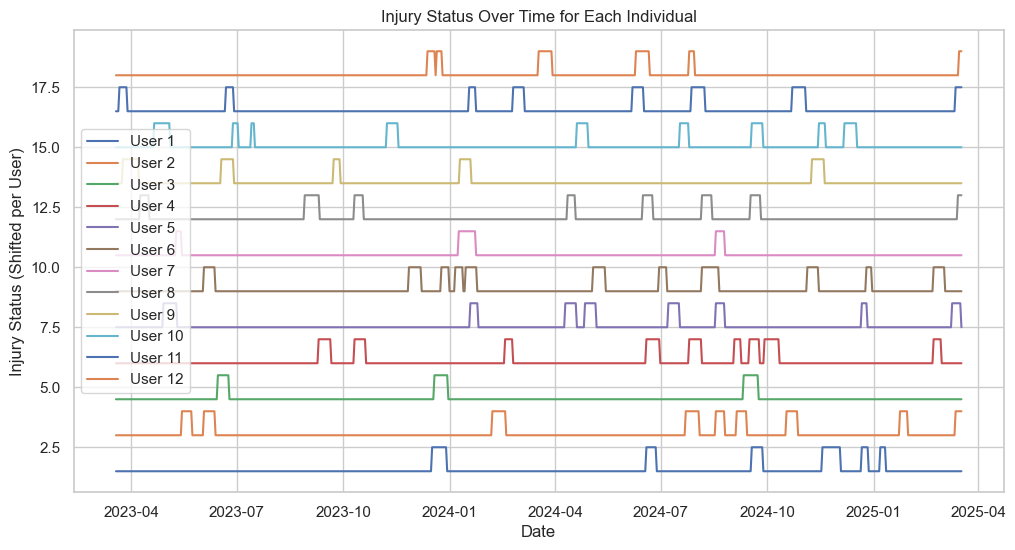

In [140]:
def plot_injury_status(df):
    plt.figure(figsize=(12, 6))
    for user_id in df["user_id"].unique():
        user_data = df[df["user_id"] == user_id]
        plt.plot(user_data["date"], user_data["currently_injured"].astype(int) + user_id * 1.5, label=f'User {user_id}')
    
    plt.xlabel("Date")
    plt.ylabel("Injury Status (Shifted per User)")
    plt.title("Injury Status Over Time for Each Individual")
    plt.legend()
    plt.show()
    return

plot_injury_status(injury_data)


In [150]:
# Define RPE tables with percentage distribution for each RPE value
rpe_tables = {
     'polarized': {
            1: 0.10, 2: 0.40, 3: 0.30, 4: 0.05, 5: 0.05, 6: 0.03, 7: 0.03, 8: 0.02, 9: 0.01, 10: 0.01
        },
     'pyramidal': {
            1: 0.10, 2: 0.20, 3: 0.20, 4: 0.15, 5: 0.15, 6: 0.10, 7: 0.05, 8: 0.03, 9: 0.01, 10: 0.01
        }
        }
training_per_week = {
    0: 0.03, 1: 0.06, 2: 0.12, 3: 0.23, 4: 0.26, 5: 0.22, 6: 0.06, 7: 0.02
}
def generate_fake_training_load_data_from_injury(injury_data, rpe_table_type='polarized', introduce_bias_n_days_before = None, max_pct_bias = None):
    """
    Generate training load data based on existing injury data.
    The training load will be assigned only on days when the user is not injured.
    
    Parameters:
    - injury_data: DataFrame generated by `generate_fake_injury_data`
    - rpe_table: Choose 'polarized' or 'pyramidal' RPE table (default is 'polarized')
    
    Returns:
    - DataFrame with training load data.
    """
    
    # Select RPE table based on user input
    if rpe_table_type == 'polarized':
        pass
    elif rpe_table_type == 'pyramidal':
        pass
    elif rpe_table_type == 'randomly_assigned_per_user_id':
        pass
    else:
        raise ValueError("Invalid rpe_table_type. Choose 'randomly_assigned_per_user_id', 'polarized', or 'pyramidal'.")
    
    df = injury_data.copy()
    df['rpe'] = np.nan
    df['duration_minutes'] = np.nan
    df['training_distribution'] = ''

    # Loop over each user in the injury data
    for user_id in df['user_id'].unique():
        user_injury_data = df[df['user_id'] == user_id]

        cur_rpe_table_type = rpe_table_type
        if rpe_table_type == 'randomly_assigned_per_user_id':
            cur_rpe_table_type = np.random.choice(list(rpe_tables.keys()))            

        rpe_table = rpe_tables[cur_rpe_table_type]

        df.loc[user_injury_data.index, 'training_distribution'] = cur_rpe_table_type

        # For each row in the injury data (one row per day)
        cur_week = -1
        for idx, row in user_injury_data.iterrows():

            if cur_week != row['date'].week:
                # A new week
                cur_week = row['date'].week
                # Determine which weekdays will be practice days
                n_training_days = np.random.choice(list(training_per_week.keys()), p=list(training_per_week.values()))
                training_days = random.sample(range(8), n_training_days)

            if row['currently_injured']:
                continue  # Skip days when the user is injured
            if not row['date'].weekday() in training_days:
                continue # Skip day as not part of random subset of training days
            
            # Generate training load on days when the user is not injured
            rpe = np.random.choice(list(rpe_table.keys()), p=list(rpe_table.values()))

            soon_to_be_injured_bias = 1
            if not introduce_bias_n_days_before is None:
                if row['days_until_next_injury'] <= introduce_bias_n_days_before:
                    pct_increase = (introduce_bias_n_days_before - row['days_until_next_injury']) / introduce_bias_n_days_before * 100
                    soon_to_be_injured_bias += pct_increase / max_pct_bias
          
            # Determine training duration based on RPE
            if rpe <= 5:
                duration = np.random.randint(75*soon_to_be_injured_bias, 121*soon_to_be_injured_bias)  # 75-120 minutes for RPE 1-5
            elif rpe <= 8:
                duration = np.random.randint(45*soon_to_be_injured_bias, 91*soon_to_be_injured_bias)  # 45-90 minutes for RPE 6-8
            else:
                duration = np.random.randint(30*soon_to_be_injured_bias, 61*soon_to_be_injured_bias)  # 30-60 minutes for RPE 9-10
            
            df.loc[idx, 'rpe'] = rpe
            df.loc[idx, 'duration_minutes'] = duration

            continue # End of for loop to iterate over current user_id
        continue # End of for loop to iterate over the different user_ids

    # # Convert the data to a DataFrame
    # df = pd.DataFrame(data, columns=["user_id", "user_name", "date", "rpe", "duration_minutes", "training_distribution"])
    return df

training_load_data = generate_fake_training_load_data_from_injury(injury_data, rpe_table_type='randomly_assigned_per_user_id')
biased_training_load_data = generate_fake_training_load_data_from_injury(injury_data, rpe_table_type='randomly_assigned_per_user_id', introduce_bias_n_days_before = 28, max_pct_bias = 100)



C:\Users\rmeer\AppData\Local\Temp\ipykernel_26172\3887490683.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['rpe'] = training_data['rpe'].astype(int)


<Figure size 1200x800 with 0 Axes>

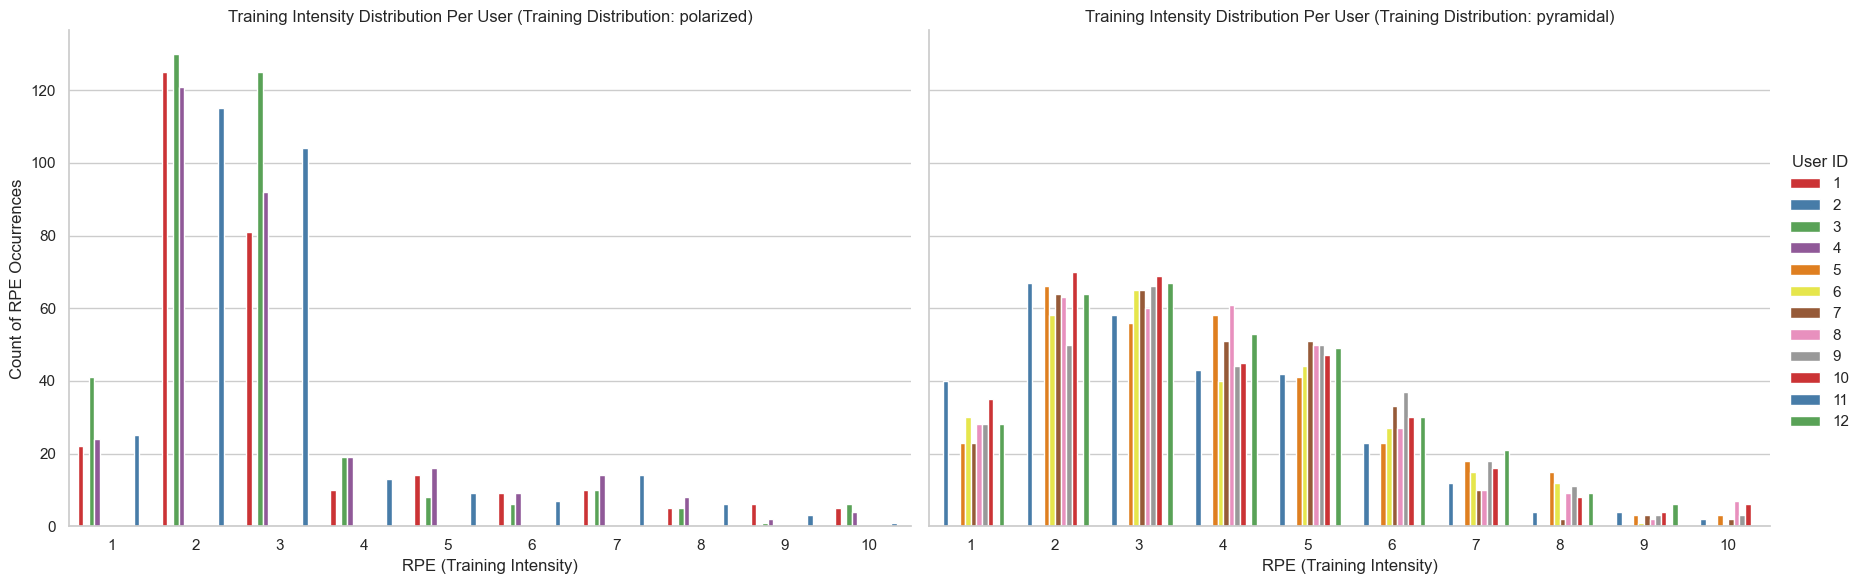

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_intensity_distribution(training_load_data):
    training_data = training_load_data.loc[training_load_data['rpe'].notnull(), :]
    
    # Ensure 'rpe' is treated as a categorical variable
    training_data['rpe'] = training_data['rpe'].astype(int)

    # Group by user_id, rpe, and training_distribution to count the occurrences
    user_rpe_distribution = training_data.groupby(['user_id', 'rpe', 'training_distribution']).size().reset_index(name='count')
    
    # Set up the plot
    plt.figure(figsize=(12, 8))
    sns.set(style="whitegrid")
    
    # Create the plot, splitting by 'training_distribution'
    g = sns.catplot(x="rpe", y="count", hue="user_id", col="training_distribution", data=user_rpe_distribution,
                    kind="bar", height=6, aspect=1.5, palette="Set1")
    
    g.set_axis_labels("RPE (Training Intensity)", "Count of RPE Occurrences")
    g.set_titles("Training Intensity Distribution Per User (Training Distribution: {col_name})")
    
    # Adjust the legend
    g.legend.set_title("User ID")
    
    plt.show()

# Example Usage:
plot_training_intensity_distribution(training_load_data)


C:\Users\rmeer\AppData\Local\Temp\ipykernel_26172\896334867.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['rpe'] = training_data['rpe'].astype(int)
C:\Users\rmeer\AppData\Local\Temp\ipykernel_26172\896334867.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rpe', y='proportion', data=user_rpe_distribution, ax=axes[i], palette="Set1")
C:\Users\rmeer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a le

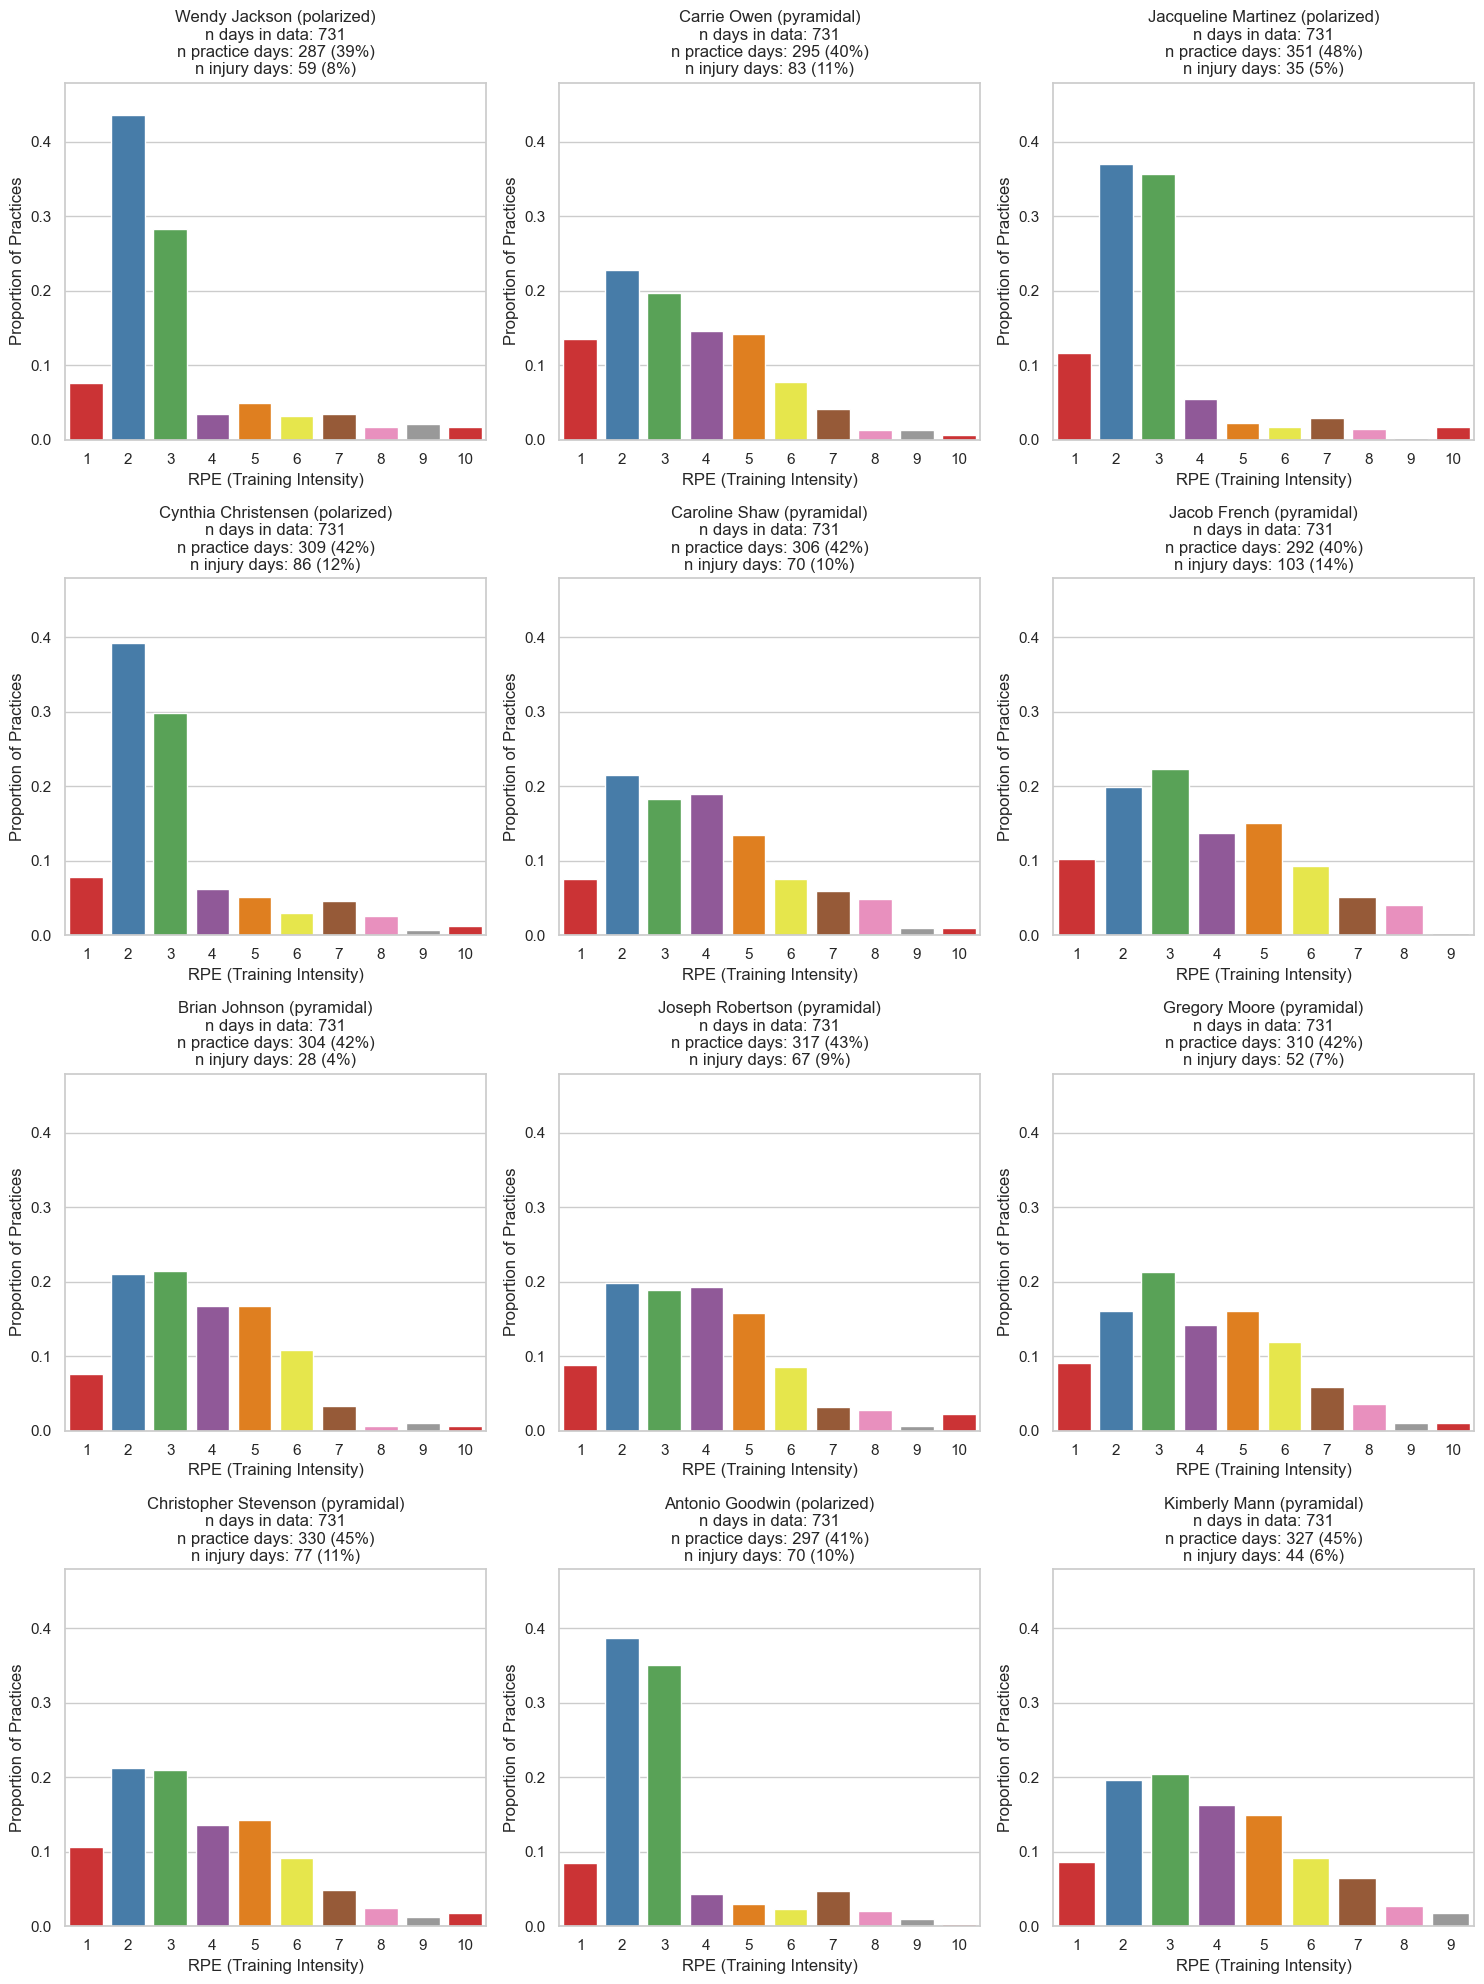

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_intensity_distribution(training_load_data):
    training_data = training_load_data.loc[training_load_data['rpe'].notnull(), :]
    # Ensure 'rpe' is treated as a categorical variable
    training_data['rpe'] = training_data['rpe'].astype(int)

    # Get unique user IDs
    user_ids = training_data['user_id'].unique()

    # Set up the plot grid: create a subplot for each user
    n_users = len(user_ids)
    n_cols = 3  # Number of columns for the subplots
    n_rows = (n_users // n_cols) + (n_users % n_cols > 0)  # Calculate number of rows required

    # Create the figure and axes for subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()  # Flatten the axes for easier indexing

    # Find the maximum proportion across all users
    max_proportion_all_users = 0
    user_max_proportions = {}

    # First, calculate the max proportion for each user to determine global max
    for user_id in user_ids:
        user_data = training_data[training_data['user_id'] == user_id]
        
        # Group by 'rpe' to count the occurrences of each RPE value for the user
        user_rpe_distribution = user_data.groupby('rpe').size().reset_index(name='count')
        
        # Calculate the total number of practices for this user
        total_practices = user_data.shape[0]
        
        # Normalize the counts to get the proportion of each RPE value
        user_rpe_distribution['proportion'] = user_rpe_distribution['count'] / total_practices
        
        # Find the maximum proportion for this user
        user_max_proportion = user_rpe_distribution['proportion'].max()
        user_max_proportions[user_id] = user_max_proportion
        
        # Update the global maximum proportion
        max_proportion_all_users = max(max_proportion_all_users, user_max_proportion)

    # Set up the plot grid and plot the data
    for i, user_id in enumerate(user_ids):
        user_data = training_data[training_data['user_id'] == user_id]
        user_injury_data = training_load_data[training_load_data['user_id'] == user_id]
        
        # Group by 'rpe' to count the occurrences of each RPE value for the user
        user_rpe_distribution = user_data.groupby('rpe').size().reset_index(name='count')
        
        # Calculate the total number of practices for this user
        total_practices = user_data.shape[0]
        
        # Normalize the counts to get the proportion of each RPE value
        user_rpe_distribution['proportion'] = user_rpe_distribution['count'] / total_practices

        # Plot the relative frequency (proportion) for each RPE value
        sns.barplot(x='rpe', y='proportion', data=user_rpe_distribution, ax=axes[i], palette="Set1")
        
        # Add the user name and training_distribution value to the title
        user_name = user_data['user_name'].iloc[0]
        training_distribution = user_data['training_distribution'].iloc[0]
        axes[i].set_title(f"{user_name} ({training_distribution})\nn days in data: {user_injury_data.shape[0]}\nn practice days: {user_injury_data['rpe'].notnull().sum()} ({user_injury_data['rpe'].notnull().sum() / user_injury_data.shape[0]*100:.0f}%)\nn injury days: {sum(user_injury_data['currently_injured']==True)} ({sum(user_injury_data['currently_injured']==True) / user_injury_data.shape[0]*100:.0f}%)", fontsize=12)
        
        # Set axis labels
        axes[i].set_xlabel("RPE (Training Intensity)")
        axes[i].set_ylabel("Proportion of Practices")
        
        # Set the y-axis limits to the same value across all users, based on the observed max proportion
        axes[i].set_ylim(0, max_proportion_all_users * 1.1)  # Add a small buffer (10%)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Example Usage:
plot_training_intensity_distribution(training_load_data)


In [151]:
training_load_data.to_csv('exported_data.csv')
biased_training_load_data.to_csv('exported_data_biased.csv')